# Exploring your fisrt PIConGPU LWFA simulation

## load python modules

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import openpmd_api as io
import openpmd_viewer as viewer

### add libaries shiped with PIConGPU 

Please adjust `PIConGPU_src` to the path to your PIConGPU source code

In [1]:
PIConGPU_src = "/users/andrezma/src/github.com/ComputationalRadiationPhysics/picongpu/"

In [2]:
import sys
sys.path.append(PIConGPU_src + "/lib/python/picongpu/")

In [4]:
# might need to be executed 2x !!! 

from extra.plugins.data import EnergyHistogramData

## set path to your simulation directory

Please adjust `path_to_simulation`

In [5]:
path_to_simulation = "/scratch/project_465001310/andrezma/01_LWFA"

## load data from energy histogram (in-situ plugin)

In [6]:
# create object for all energy histogram data
eh_data = EnergyHistogramData(path_to_simulation) # the directory in which simOutput is located

In [7]:
# show available iterations
print("1:", eh_data.get_iterations(species='e'), "\n")

# show available simulation times
print("2.", eh_data.get_times(species='e'))

1: [   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000] 

2. [0.000e+00 1.390e-14 2.780e-14 4.170e-14 5.560e-14 6.950e-14 8.340e-14
 9.730e-14 1.112e-13 1.251e-13 1.390e-13 1.529e-13 1.668e-13 1.807e-13
 1.946e-13 2.085e-13 2.224e-13 2.363e-13 2.502e-13 2.641e-13 2.780e-13]


In [8]:
# load data for a given iteration
counts, bins_keV, _, _ = eh_data.get(species='e', species_filter='all', iteration=2000)

### plot energy histogram 

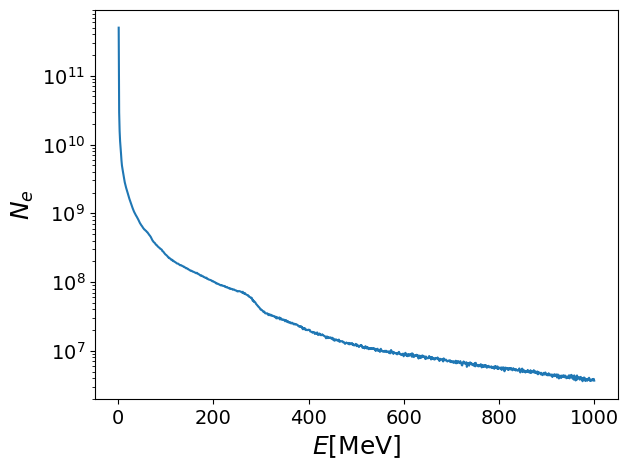

In [11]:
plt.plot(bins_keV, counts)

plt.xlabel(r"$E \mathrm{[MeV]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$N_e$", fontsize=18)
plt.yticks(fontsize=14)
plt.yscale("log")

plt.tight_layout()
plt.show()

### some more options:

In [12]:
# load data for a given time
counts, bins_keV, iteration, dt = eh_data.get(species='e', species_filter='all', time=1.3900e-14)

In [13]:
# get data for multiple iterations
counts, bins_keV, iteration, dt = eh_data.get(species='e', iteration=[200, 400, 1000])

## load openPMD series

(no changes needed)

In [14]:
series = io.Series(path_to_simulation + "/simOutput/openPMD/simData_%06T.bp", access=io.Access_Type.read_only)

### select a time step (iteration)

choose any valid output time step

In [15]:
time_step = 1500

it = series.iterations[time_step]

### what attributes are there?

In [16]:
for i in it.attributes:
    print(i)

cell_depth
cell_height
cell_width
dt
eps0
iteration
mue0
particleBoundary
particleBoundaryParameters
sim_slides
time
timeUnitSI
unit_bfield
unit_charge
unit_efield
unit_energy
unit_length
unit_mass
unit_speed
unit_time


let's get the grid resolution:

In [17]:
delta_x = it.get_attribute('cell_width')
delta_y = it.get_attribute('cell_height')
unit_length = it.get_attribute('unit_length')

# convert to SI units
delta_x *= unit_length
delta_y *= unit_length

print(delta_x, delta_y) # in meter

1.7719999774007647e-07 4.429999943501912e-08


### load mesh data

In [19]:
# load electron density

h = it.meshes["e_all_chargeDensity"] # [io.Mesh_Record_Component.SCALAR]

print("shape:", h.shape)
N_x, N_y, N_z = h.shape

shape: [192, 1536, 192]


In [20]:
# load a slice of the 3D data 

n_e = h[:, :, 192//2]
n_e_SI = h.unit_SI
series.flush()
n_e *= n_e_SI / const.elementary_charge * -1

### generate axis of mesh data

In [21]:
x = (np.arange(N_x) - N_x//2) * delta_x
y = np.arange(N_y) * delta_y

### plot mesh data

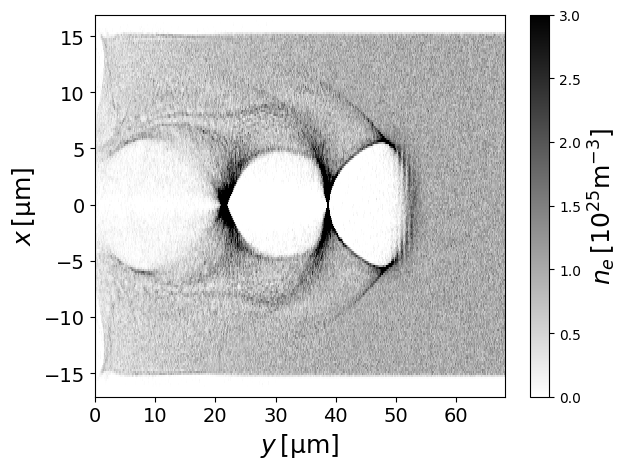

In [22]:
plt.pcolormesh(y/1e-6, x/1e-6, n_e/1e25, cmap=plt.cm.gray_r, vmax=3)

plt.xlabel(r"$y \, \mathrm{[\mu m]}$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$x \, \mathrm{[\mu m]}$", fontsize=18)
plt.yticks(fontsize=14)

cb = plt.colorbar()
cb.set_label(r"$n_e \, \mathrm{[10^{25} m^{-3}]}$", fontsize=18)

plt.tight_layout()
plt.show()

### more meshes 

There are are moshes to explore:

In [23]:
for i in it.meshes:
    print(i)

B
E
e_all_chargeDensity
e_all_energyDensity
picongpu_idProvider


feel free to add your own code

## load particle data

In [24]:
# macro particle weighting

h = it.particles["e"]["weighting"][io.Mesh_Record_Component.SCALAR]

print("number of particles:", h.shape)

w = h.load_chunk()
w_SI = h.unit_SI
series.flush()
w *= w_SI

number of particles: [110946389]


In [25]:
# momentum component

h = it.particles["e"]["momentum"]["y"]

p_y = h.load_chunk()
p_y_SI = h.unit_SI
series.flush()
p_y *= p_y_SI / w / const.electron_mass / const.speed_of_light

### plot particle data

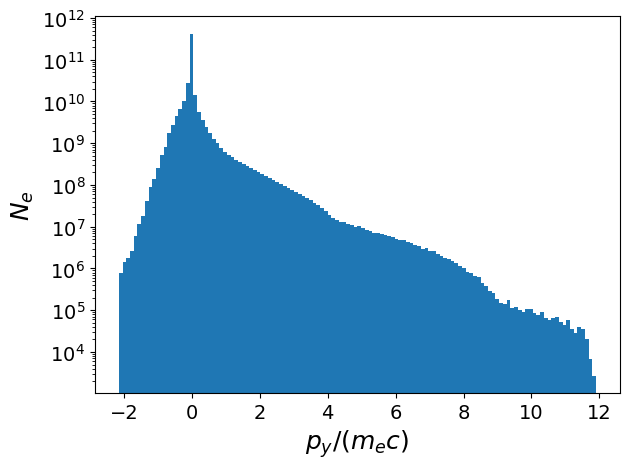

In [26]:
plt.hist(p_y, weights=w, bins=128)
plt.yscale("log")


plt.xlabel(r"$p_y /(m_e c)$", fontsize=18)
plt.xticks(fontsize=14)

plt.ylabel(r"$N_e$", fontsize=18)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

### there is more particle data to explore

In [27]:
for i in it.particles["e"]:
    print(i)

charge
mass
momentum
position
positionOffset
weighting


feel free to writhe your own data analysis

In [ ]:
from extra.plugins.plot_mpl import EnergyHistogramMPL

In [ ]:
!ls /scratch/project_465001310/pauschri/08_LWFA_4_nores_mappedMemory/simOutput